In [261]:
import numpy as np
# import scipy.stats as ss
# from scipy.spatial import distance_matrix
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import SpectralClustering
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm import tqdm
from collections import defaultdict

In [294]:
INPUT_PATH="/mnt/geofflab/SNP_barcoding/Lvar_annotations_v3_Jan2021/transcripts.csv"
COUNTS_PATH="/mnt/geofflab/SNP_barcoding/LV_counts_10hpf.csv"

In [26]:
# import sys
# print(sys.version)

3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]


In [174]:
# df = pd.read_csv(INPUT_PATH)
# print(np.sort(np.unique(df["chromosome"])))
# print()
# df_chr13_sorted = df[df["chromosome"] == 13].sort_values(by=["start"])
# print(df_chr13_sorted.head(1).index[0])
# print()
# print(df_chr13_sorted.tail())
# print(df_chr13_sorted["start"].iloc[0])
# print(df_chr13_sorted["end"].iloc[-1])
# print(range(df_chr13_sorted["start"].iloc[0],df_chr13_sorted["end"].iloc[-1]))
# print()
# chiasma_point = random.choice(range(df_chr13_sorted["start"].iloc[0],df_chr13_sorted["end"].iloc[-1]))
# print(f"chiasma point: {chiasma_point}")
# print()
# for idx,transcript_entry in df_chr13_sorted.iterrows():
#     gene,chromosome,start,end,direction,sequence = transcript_entry
#     if chiasma_point < start: 
#         print(str(idx)+"\n")
#         print(transcript_entry)
#         if chiasma_point in range(start,end+1):
#             print("\nChiasma point in transcript!")
#         break

# plt.hist(x=df_chr13_sorted["start"])
# plt.show()
# plt.hist(x=df_chr13_sorted["end"])
# plt.show()

# gene,chromosome,start,end,direction,sequence = df.loc[1,:]
# print(gene,chromosome,start,end,direction)
# # TODO: why these don't match
# print(start,end,end-start)
# print(len(sequence))
# print(sequence)

In [242]:
# chromatid = {
#     "chr13":{
#         "gene1":"abcd",
#         "gene2":"bcd"
#     },
#     "chr19":{
#         "gene3":"ACGT",
#         "gene4":"TGCA"
#     }
# }

# chromatid = defaultdict(dict)
# chromatid["chr13"]["gene1"] = "abcd"
# chromatid["chr13"]["gene2"] = "bcd"
# # chromatid["chr13"] = {"gene12":"bcd"}
# chromatid["chr19"]["gene3"] = "ACGT"
# chromatid["chr19"]["gene4"] = "TGCA"
# chromatid["chr21"]["gene5"] = "pp"

# print(chromatid)
# print(chromatid["chr19"]["gene3"])

# test = {"a":1,"c":2,"g":3,"t":4}
# for key in test:
#     print(key)

In [346]:
heterozygosity = 0.0045
alphabet = {"A":0, "C":1, "G":2, "T":3}
genotypes = {
    "AA":0, "AC":1, "AG":2, "AT":3, 
    "CA":1, "CC":4, "CG":5, "CT":6,
    "GA":2, "GC":4, "GG":7, "GT":8, 
    "TA":3, "TC":6, "TG":8, "TT":9,
}

class EmbryoSequenceSimulator:
    def __init__(self, input_df, n_embryos):
        
        # pd data frame
        self.input_df = input_df # cols: gene,chromosome,start,end,direction,sequence
        self.n_embryos = n_embryos
        
        # Number of cells that can be harvested from embryo
        self.avg_harvested_cells = 10
        self.sd_harvested_cells = 1
        self.alphabet = {"A":0, "C":1, "G":2, "T":3}
        
        # Global parental chromatid maps
        self.m0_chromatid = None
        self.m1_chromatid = None
        self.p0_chromatid = None
        self.p1_chromatid = None
        
    def global_seeding(self, heterozygosity):
        """
        Uniform seeding of SNP locations for each gene with frequency according to heterozygosity.
        Parental chromatid seeding (2 chromatids from mother, 2 chromatids from father)
        """
        
        # Setting SNP positions for each transcript in input_df
        snp_map = defaultdict(dict)
        sequence_map = defaultdict(dict)
        for idx,transcript_entry in self.input_df.iterrows():
            gene,chrom,start,end,direction,sequence = transcript_entry
            N = len(sequence)
            num_snps = round(N*heterozygosity)
            snp_positions = np.sort(random.sample(range(N),num_snps))
            snp_map[chrom][gene] = snp_positions
            sequence_map[chrom][gene] = sequence
        
        # Setting parental chromatid maps
        for parent in ["m0","m1","p0","p1"]:
            
            chromatid = defaultdict(dict)
            for chrom,genes in snp_map.items():
        
                # TODO: add transition probability wrt reference (transcript/chromosome specific, 
                #       look at Kramer paper)
                
                for gene,snp_positions in genes.items():
                    snp_profile = {locus:random.choice(list(self.alphabet.keys())) for locus in snp_positions}
                    
                    sequence_list = [char for char in sequence_map[chrom][gene]]
                    for locus,char in snp_profile.items():
                        sequence_list[locus] = char
                    
                    chromatid[chrom][gene] = "".join(sequence_list)
                
            # Assign seeded parental chromatid to its class field (global over all embryos)
            if parent == "m0":
                self.m0_chromatid = chromatid
            elif parent == "m1":
                self.m1_chromatid = chromatid
            elif parent == "p0":
                self.p0_chromatid = chromatid
            elif parent == "p1":
                self.p1_chromatid = chromatid
                
        return snp_map
    
    def embryo_population_simulation(self, count_df=None):
        """
        Simulating SNP profile for each embryo across all transcript entries in input_df.
        For this simulator, not explicitly generating scRNA-seq reads for each embryo (reduces space)
        """

        # map: idx of transcript entry -> list of snp positions
        snp_map = self.global_seeding(heterozygosity)
        true_clusters = []
        cluster_label = 0
        
        population_profile = []
        for _ in range(self.n_embryos):
            
            # each entry a list of genotypes for an embryo across all transcripts
            if count_df is not None:
                snp_profile = self.determine_embryo_genotype(snp_map,count_df)
            else:
                snp_profile = self.determine_embryo_genotype(snp_map)
            
            # Harvest some number of cells, which will theoretically have identical SNP profiles
            n_harvested_cells = round(np.random.normal(self.avg_harvested_cells,self.sd_harvested_cells))
            for __ in range(n_harvested_cells):
                population_profile.append(snp_profile)
                true_clusters.append(cluster_label)
            cluster_label += 1
                
        return np.array(population_profile),true_clusters
    
    def determine_embryo_genotype(self, snp_map, count_df=None):
        """
        Simulate array containing genotypes over all transcripts 
        (concatenated into single list)
        """
        
        dropout_flag = False if count_df is None else True # flag if count_df is detected
        if dropout_flag:
            sampled_profile = random.choice(count_df.columns.tolist()[2:])
            dropout_profile = {}
            for idx,row in count_df[["Lv_name",sampled_profile]].iterrows():
                gene,count = row
                dropout_profile[gene] = 0 if count == 0 else 1
        
        # state (genotype) across all transcripts
        snp_genotypes = []
                
        # map: idx of transcript entry -> sequence after homologous recombination
        m_chromatid,p_chromatid = self.simulate_embryo_sequence(snp_map)
        for chrom,genes in snp_map.items():
            for gene,snp_positions in genes.items():
                if dropout_flag:
                    if dropout_profile[gene] == 0:
                        for locus in snp_positions:
                            snp_genotypes.append(-1)
                        continue
                m_sequence = m_chromatid[chrom][gene]
                p_sequence = p_chromatid[chrom][gene]
                for locus in snp_positions:
                    snp_genotype = "".join([m_sequence[locus],p_sequence[locus]])
                    snp_genotypes.append(genotypes[snp_genotype])
                
        return snp_genotypes
                
    def simulate_embryo_sequence(self,snp_map):
        """
        Given seeded parental chromatids and a map of SNP locations for each transcript,
        simulate embryo sequences
        """
        
        updated_m0,updated_m1 = defaultdict(dict),defaultdict(dict)
        updated_p0,updated_p1 = defaultdict(dict),defaultdict(dict)
        
        for parent in ["mother","father"]:
            
            # Consider homologous recombination with respect to each chromosome
            for chr_num in np.sort(np.unique(df["chromosome"])):
                
                # Subset df for specific chr, sorted by start position 
                chr_df = self.input_df[self.input_df["chromosome"] == chr_num].sort_values(by=["start"])
                
                # Chiasma point chosen over range of transcripts reads
                transcript_range = range(chr_df["start"].iloc[0], chr_df["start"].iloc[-1]+len(chr_df["sequence"].iloc[-1])) 
                chiasma = random.choice(transcript_range)
                chiasma_flag = 1 # 1 means chiasma has not been reached; 0 means passed chiasma
                for idx,transcript_entry in chr_df.iterrows():
                    if parent == "mother":
                        chiasma_flag = self.homologous_recombination(
                            transcript_entry = transcript_entry,
                            updated_c0 = updated_m0,
                            updated_c1 = updated_m1,
                            c0 = self.m0_chromatid,
                            c1 = self.m1_chromatid,
                            chiasma = chiasma,
                            flag = chiasma_flag
                        )
                    else:
                        chiasma_flag = self.homologous_recombination(
                            transcript_entry = transcript_entry,
                            updated_c0 = updated_p0,
                            updated_c1 = updated_p1,
                            c0 = self.p0_chromatid,
                            c1 = self.p1_chromatid,
                            chiasma = chiasma,
                            flag = chiasma_flag
                        )

        m_chromatid = self.chromosome_inheritance(updated_m0, updated_m1)
        p_chromatid = self.chromosome_inheritance(updated_p0, updated_p1)
        
        return m_chromatid,p_chromatid
    
    def homologous_recombination(self,transcript_entry,updated_c0,updated_c1,c0,c1,chiasma,flag):
        
        gene,chrom,start,end,direction,sequence = transcript_entry
        
        if flag <= start and flag == 1:
            flag = 0
            if chiasma in range(start,start+len(sequence)):
                updated_c0[chrom][gene] = c0[chrom][gene][:chiasma]+c1[chrom][gene][chiasma:]
                updated_c1[chrom][gene] = c1[chrom][gene][:chiasma]+c0[chrom][gene][chiasma:]
                return flag

        if flag == 1: # Before chiasma point has been reached
            updated_c0[chrom][gene] = c0[chrom][gene]
            updated_c1[chrom][gene] = c1[chrom][gene]
        else: # After chiasma point has been reached
            updated_c0[chrom][gene] = c1[chrom][gene]
            updated_c1[chrom][gene] = c0[chrom][gene]
        
        return flag
    
    def chromosome_inheritance(self,c0,c1):
        
        chromatid = defaultdict(dict)
        for chrom in c0:
            chromatid[chrom] = c0[chrom] if random.random() <= 0.5 else c1[chrom]
        
        return chromatid
                  
    

In [349]:
n_embryos = 10
df = pd.read_csv(INPUT_PATH)
df = df.dropna()
# df = df.loc[:100,:]
# df = df.sample(250)

count_df = pd.read_csv(COUNTS_PATH)
count_df = count_df[count_df["Lv_name"] != "LVA_m28240.t1"]

simulator = EmbryoSequenceSimulator(df, n_embryos)
X,true_clusters = simulator.embryo_population_simulation(count_df)
print(X.shape)
print(X)

(100, 254852)
[[-1 -1 -1 ...  1 -1 -1]
 [-1 -1 -1 ...  1 -1 -1]
 [-1 -1 -1 ...  1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


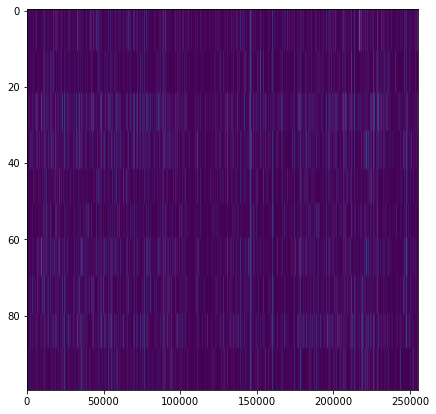

In [350]:
fig,ax = plt.subplots(figsize=(7,7))
ax.imshow(X, aspect='auto')
plt.show()

In [356]:
# def hamming(g0, g1):
#     n_mismatches = 0
#     for i, j in zip(g0, g1):
#         if i != j: n_mismatches += 1
#     return n_mismatches

# # Hamming distance all-vs-all matrix
# distX = np.zeros((X.shape[0],X.shape[0]))
# for i in tqdm(range(X.shape[0])):
#     for j in range(X.shape[0]):
#         distX[i,j] = hamming(X[i,:], X[j,:])

# fig,ax = plt.subplots(figsize=(9,7))
# h1 = ax.imshow(distX, aspect='auto')
# fig.colorbar(h1, ax=ax)
# plt.show()

100%|██████████| 100/100 [11:10<00:00,  6.71s/it]


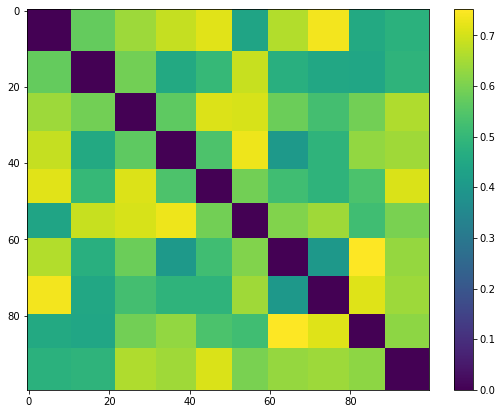

In [352]:
def adjustedHamming(s1, s2):
    if len(s1) != len(s2):
        raise ValueError("Sequence lengths unequal.")
    else:
        hd,adjlen = 0, 0
        for i, j in zip(s1, s2):
            if i == -1 or j == -1: 
                continue
            adjlen += 1
            if i != j: 
                hd += 1
        return hd, adjlen

# Introduce uniform dropout
n,m = X.shape
# dropoutX = np.copy(X)
# dropout = 0.3
# for i in range(n):
#     for j in range(m):
#         if random.random() <= dropout:
#             dropoutX[i,j] = -1

# print(dropoutX.shape)
# print(dropoutX)

# Hamming distance all-vs-all matrix
hd = np.zeros((n,n))
adjlen = np.zeros((n,n))
for i in tqdm(range(n)):
    for j in range(n):
        adjusted_hamming,length = adjustedHamming(X[i,:], X[j,:])
        hd[i,j] = adjusted_hamming
        adjlen[i,j] = length

ddistX = np.divide(hd,adjlen)
fig,ax = plt.subplots(figsize=(9,7))
h1 = ax.imshow(ddistX, aspect='auto')
fig.colorbar(h1, ax=ax)
plt.show()

In [353]:
clusters = SpectralClustering(n_clusters=n_embryos,assign_labels="discretize").fit(X)
print(clusters.labels_)

[6 6 6 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 0 0 0 0 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4
 4 4 4 4 4 9 9 9 9 9 9 9 9 9 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 7 7 7 7
 7 7 7 7 7 7 0 0 0 0 0 0 0 0 0 1 8 8 8 8 8 8 8 1 8 8]


/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [354]:
print(adjusted_rand_score(true_clusters,clusters.labels_))

0.8684301995117503


In [355]:
# df = pd.read_csv(INPUT_PATH)
# df = df.dropna()

# count_df = pd.read_csv(COUNTS_PATH)
# count_df = count_df[count_df["Lv_name"] != "LVA_m28240.t1"]

# df_set = set(df["gene"])
# count_df_set = set(count_df["Lv_name"])

# print(len(df_set))
# print(len(count_df_set))

# print(df_set.difference(count_df_set))
# print(count_df_set.difference(df_set))